# Convolutional autoencoders

In this script we write a CNN autoencoder and apply it to the task of image desnoising.

<center><a href="https://en.wikipedia.org/wiki/Total_variation_denoising">
    <img src="https://upload.wikimedia.org/wikipedia/commons/e/e8/ROF_Denoising_Example.png"></a></center>


In [92]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import copy

In [93]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02, generator=torch.manual_seed(seed))
        m.bias.data.fill_(0.01)
    return

# Plot function
def myplot(x):
    plt.figure()
    plt.imshow(x.detach().squeeze().numpy(), cmap='gray')
    plt.show()
    return

## Transposed convolution

As seen in the previous lab, convolution usually reduces the size of the image (except if we compensate using padding). However, in some applications (e.g., image synthesis from low-dimension features) it is usefull to increase it. That's notably needed for autoencoders, since after projecting the data into a compact latent representation, we need to expand this representation back into the image space.

This is exactly what [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d) does. Simply put, a transposed convolution adds some zeros inside the input image (and on the edge) to artificially increase the size.

Convolution             |  Transposed convolution
:-------------------------:|:-------------------------:
![](https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif)  |  ![](https://miro.medium.com/max/395/1*Lpn4nag_KRMfGkx1k6bV-g.gif)


On the left, we use convolution with a kernel size of 3 and stride of 2. On the right, we then use a transposed convolution with the same parameters, and its effect is to procude an image with the same size as the original.

torch.Size([1, 1, 343, 550])


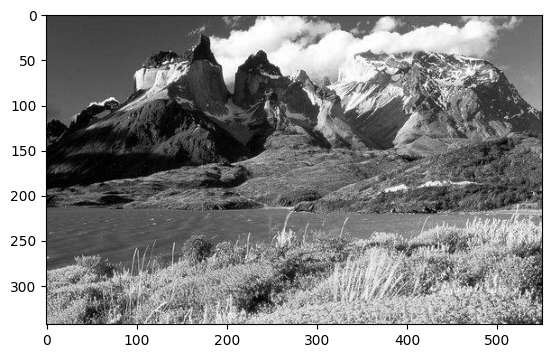

In [94]:
# Load the provided example image, and convert it in black and white
image_t = torchvision.io.read_image('tdp.jpeg', mode=torchvision.io.ImageReadMode.RGB)
image_t = torchvision.transforms.functional.rgb_to_grayscale(image_t)

# Convert as a float tensor, normalize it so the values range in [0, 1], and expand to a batch
image_t = image_t.float()
image_t /= image_t.max()
image_t = image_t.unsqueeze(0)

# Print the shape and plot it
print(image_t.shape)
myplot(image_t)

Original image:  torch.Size([1, 1, 343, 550])
Output of the convolution :  torch.Size([1, 1, 86, 137])


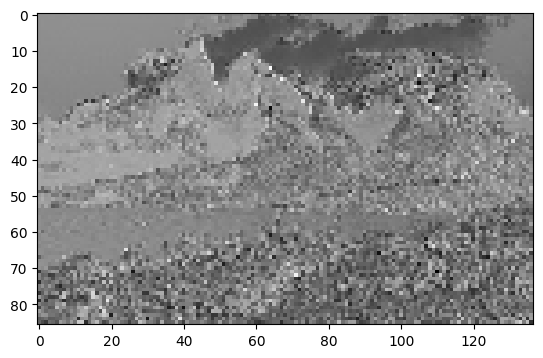

In [95]:
num_channels_in = 1
num_channels_out = 1

# First, let us apply a convolution with a kernel size of (3, 6) and a stride of 4.
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4)
output = my_conv(image_t)
print('Original image: ', image_t.shape)
print('Output of the convolution : ', output.shape)

# Display the output after convolution
myplot(output)

After applying transposed convolution :  torch.Size([1, 1, 343, 550])


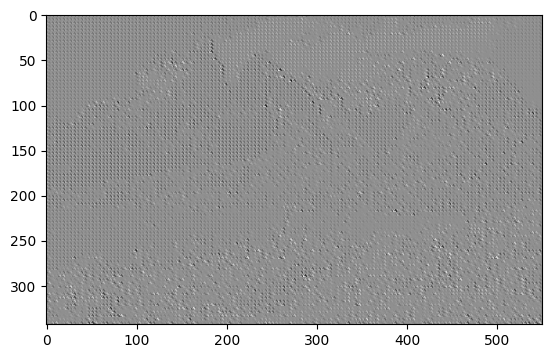

In [96]:
# Now we reproduce an image with the same size as the original input
my_convt = nn.ConvTranspose2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4)
image_convt = my_convt(output)
print('After applying transposed convolution : ', image_convt.shape)

# Display the output after transposed convolution
myplot(image_convt)

As you can see, transposed convolution does not invert convolution (it's not "deconvolution"): it only guarantees that the size will be equal to that of the image before convolution (but not its pixel values).

## Dataset

In [97]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Load the MNIST dataset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(train_data, torch.arange(50))

# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## CNN autoencoder

As seen in lab 4, autoencoders are networks that project the input data into a low-dimension space, and then expand this compact representation back into the input space. In CNN autoencoders, the encoder uses convolutions to reduce the image size, while the decoder uses transposed convolutions to expand it. We propose the following architecture:

- The encoder consists of two layers, with a convolution function, a RELU and a max pooling. The convolution functions have a kernel size of 3 and a padding of 1. They use 16 and 4 output channels, respectively. The max pooling functions use a kernel size of 2.

- The decoder consists of two layers, with a transposed convolution and an activation function (RELU for the first layer, Sigmoid for the second layer). The transposed convolution functions have a kernel size of 2 and a stride of 2. They use 16 and 1 output channels, respectively.

In [98]:
# TO DO: write the CNN autoencoder module ('__init__' and 'forward' methods)
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded




In [99]:
# Instantiate the CNN autoencoder, initialize it, and print the number of parameters
model_cnn_ae = CNNAutoencoder()
model_cnn_ae.apply(init_params)
print('Total number of parameters:', sum(p.numel() for p in model_cnn_ae.parameters()))

Total number of parameters: 1077


In [100]:
# Before training, make sure that the output of the autoencoder has the same shape as its input.
# If that's not the case, there's something to debug somewhere.
image_batch_example = next(iter(train_dataloader))[0]
out = model_cnn_ae(image_batch_example)
print(image_batch_example.shape)
print(out.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])


In [101]:
# TO DO: write the autoencoder training function with validation (also write the evaluation function)
# It's similar to the MLP autoencoder (lab 4.2), but images don't need to be vectorized

# Evaluation function
def evaluate_autoencoder(autoencoder, dataloader, criterion):
    autoencoder.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs in dataloader:
            # inputs = inputs[0].view(-1, 28*28)
            inputs = inputs[0]
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
    return running_loss / len(dataloader)

In [102]:
def train_autoencoder(autoencoder, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(autoencoder.state_dict())
    best_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        for inputs in train_dataloader:
            # print(len(inputs[0]))
            inputs = inputs[0]
            # inputs = inputs[0].view(-1, 28*28)
            optimizer.zero_grad()
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_valid_loss = evaluate_autoencoder(autoencoder, valid_dataloader, criterion)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            best_model_wts = copy.deepcopy(autoencoder.state_dict())
        print(f'Epoch {epoch+1}/{num_epochs} : Train Loss = {epoch_train_loss:.4f} - Valid Loss = {epoch_valid_loss:.4f}')
    autoencoder.load_state_dict(best_model_wts)
    return autoencoder, train_losses, valid_losses

<span style="color:red">**Exercice 3**</span> Using the training parameters below, train the model and plot the training and validation losses on the same plot.

In [103]:
# Training parameters
num_epochs = 50
loss_fn = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model_cnn_ae.parameters(), lr=learning_rate)


In [104]:
best_model, train_loss_values, valid_loss_values = train_autoencoder(model_cnn_ae, train_dataloader, valid_dataloader, loss_fn, optimizer, num_epochs)


Epoch 1/50 : Train Loss = 1.1858 - Valid Loss = 1.1215
Epoch 2/50 : Train Loss = 0.8496 - Valid Loss = 0.6941
Epoch 3/50 : Train Loss = 0.6180 - Valid Loss = 0.6240
Epoch 4/50 : Train Loss = 0.5821 - Valid Loss = 0.6012
Epoch 5/50 : Train Loss = 0.5634 - Valid Loss = 0.5832
Epoch 6/50 : Train Loss = 0.5468 - Valid Loss = 0.5682
Epoch 7/50 : Train Loss = 0.5352 - Valid Loss = 0.5591
Epoch 8/50 : Train Loss = 0.5283 - Valid Loss = 0.5530
Epoch 9/50 : Train Loss = 0.5236 - Valid Loss = 0.5484
Epoch 10/50 : Train Loss = 0.5197 - Valid Loss = 0.5448
Epoch 11/50 : Train Loss = 0.5166 - Valid Loss = 0.5414
Epoch 12/50 : Train Loss = 0.5138 - Valid Loss = 0.5390
Epoch 13/50 : Train Loss = 0.5116 - Valid Loss = 0.5363
Epoch 14/50 : Train Loss = 0.5097 - Valid Loss = 0.5345
Epoch 15/50 : Train Loss = 0.5081 - Valid Loss = 0.5332
Epoch 16/50 : Train Loss = 0.5068 - Valid Loss = 0.5318
Epoch 17/50 : Train Loss = 0.5056 - Valid Loss = 0.5306
Epoch 18/50 : Train Loss = 0.5046 - Valid Loss = 0.5298
E

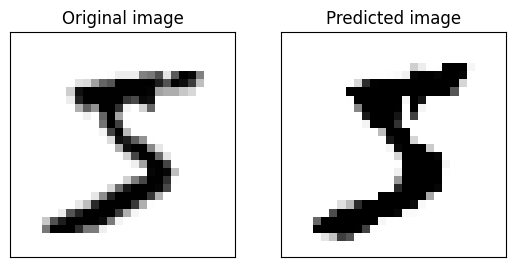

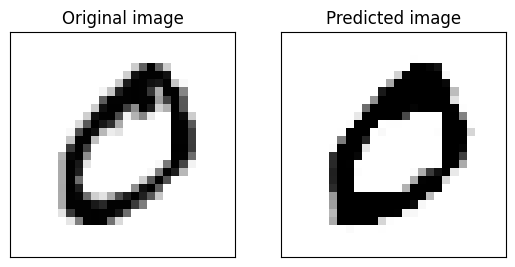

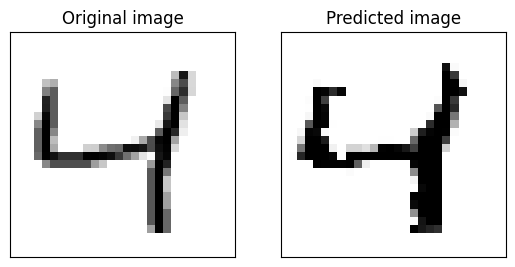

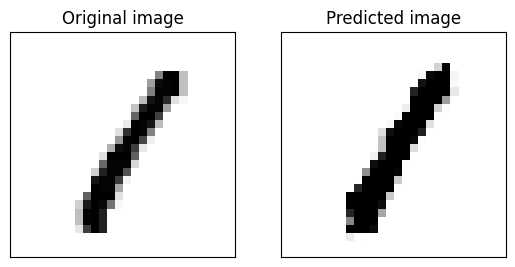

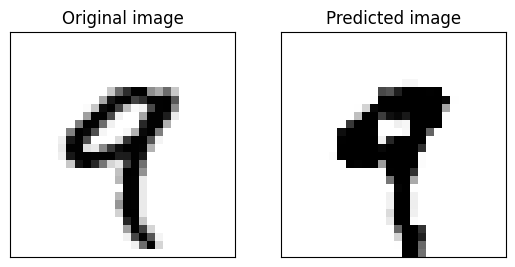

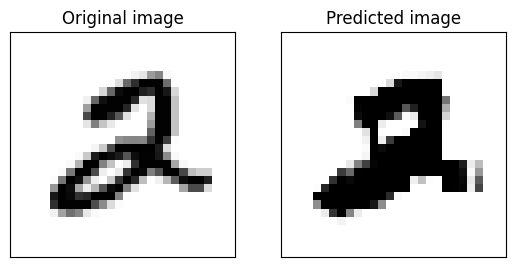

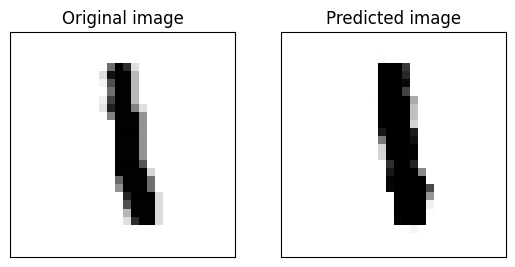

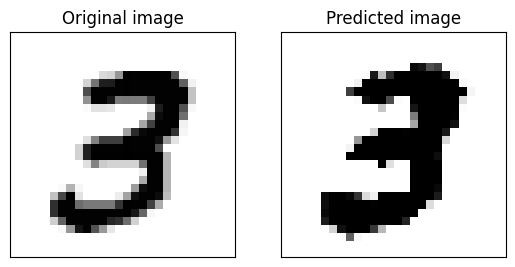

In [105]:
# Vizualization

# Get an example batch from the test set
test_batch_example = next(iter(test_dataloader))[0]

# Pass it to the autoencoder
with torch.no_grad():
    test_batch_example_pred = best_model(test_batch_example)

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(test_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(test_batch_example_pred[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()

## Denoising autoencoder

We now consider an application of autoencoders, which is image denoising. We use the same CNN autoencoder model as above, but the thing that changes is the data on which it is trained. Indeed, the denoising autoencoder takes as inputs the noisy images, and outputs clean (denoised) imaged. However, we don't need to create a new dataset with noisy images: we simply need to add noise to the images during training before passing them to the model.

<center><a href="https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*SxwRp9i23OM0Up4sEze1QQ@2x.png" width="550"></a></center>


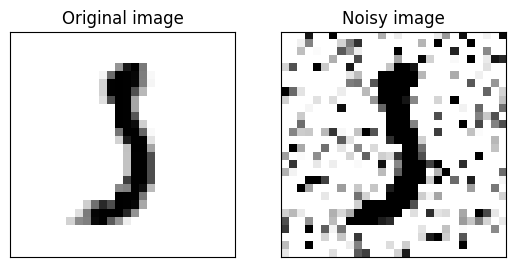

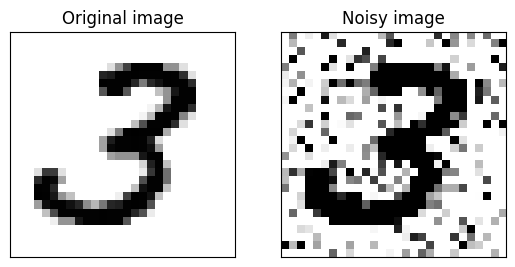

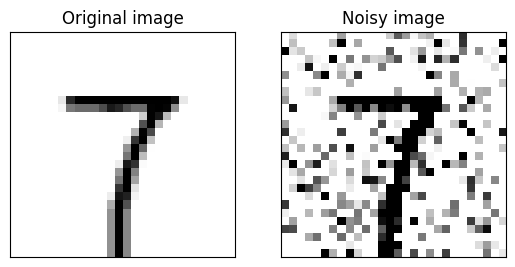

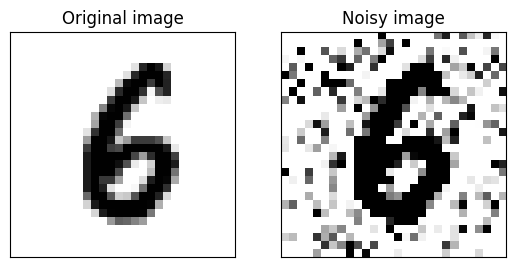

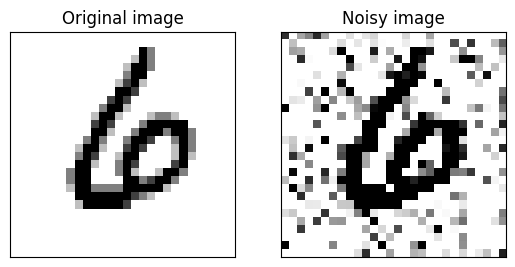

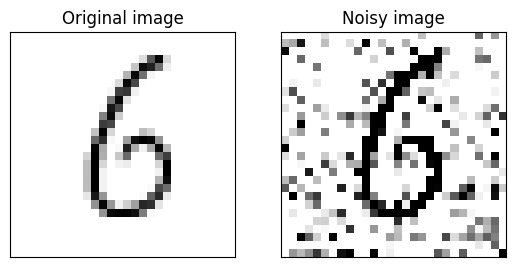

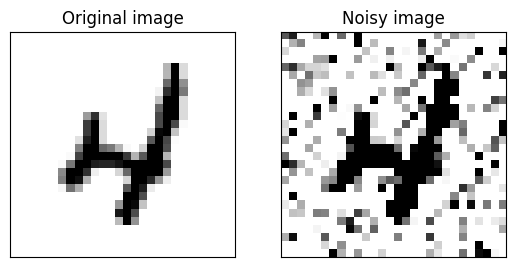

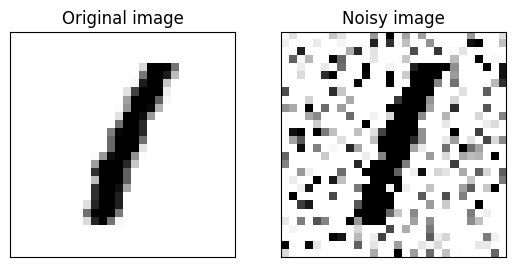

In [106]:
# First, here is a function that adds some noise to an input image batch
def add_noise(inputs,noise_factor=0.8):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

# Add noise to the image_batch_example
noisy_images_batch = add_noise(image_batch_example)

# Plot the original and noisy images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_images_batch[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.show()

The training function is the same as before, except that we need to add the noise to the images before passing them to the model. Then, we compute the loss between the original images (clean) and the output of the model (denoised).

<span style="color:red">**Exercice 4**</span> Instanciate a CNN autoencoder and initialize its parameters. Using the same training parameters as above, train the model for the denoising task. After training, plot the training and validation losses over epochs (on the same plot).

In [107]:
def train_noisy_autoencoder(autoencoder, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(autoencoder.state_dict())
    best_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        for inputs in train_dataloader:
            # print(len(inputs[0]))
            inputs = add_noise(inputs[0])
            # inputs = inputs[0].view(-1, 28*28)
            optimizer.zero_grad()
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_valid_loss = evaluate_autoencoder(autoencoder, valid_dataloader, criterion)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            best_model_wts = copy.deepcopy(autoencoder.state_dict())
        print(f'Epoch {epoch+1}/{num_epochs} : Train Loss = {epoch_train_loss:.4f} - Valid Loss = {epoch_valid_loss:.4f}')
    autoencoder.load_state_dict(best_model_wts)
    return autoencoder, train_losses, valid_losses

In [108]:
# TO DO: write the training function (with validation) for the denoising autoencoder

model_cnn_den_ae = CNNAutoencoder()
model_cnn_den_ae.apply(init_params)
print('Total number of parameters:', sum(p.numel() for p in model_cnn_den_ae.parameters()))

optimizer = torch.optim.Adam(model_cnn_den_ae.parameters(), lr=learning_rate)

# Train the model
model_cnn_den_ae_tr, train_loss_values, valid_loss_values = train_noisy_autoencoder(model_cnn_den_ae, train_dataloader, valid_dataloader, loss_fn, optimizer, num_epochs)


Total number of parameters: 1077
Epoch 1/50 : Train Loss = 0.1970 - Valid Loss = 1.2574
Epoch 2/50 : Train Loss = 0.1592 - Valid Loss = 1.0414
Epoch 3/50 : Train Loss = 0.1329 - Valid Loss = 0.8502
Epoch 4/50 : Train Loss = 0.1151 - Valid Loss = 0.7544
Epoch 5/50 : Train Loss = 0.1105 - Valid Loss = 0.7324
Epoch 6/50 : Train Loss = 0.1074 - Valid Loss = 0.7007
Epoch 7/50 : Train Loss = 0.1040 - Valid Loss = 0.6714
Epoch 8/50 : Train Loss = 0.0997 - Valid Loss = 0.6404
Epoch 9/50 : Train Loss = 0.0952 - Valid Loss = 0.6163
Epoch 10/50 : Train Loss = 0.0922 - Valid Loss = 0.6009
Epoch 11/50 : Train Loss = 0.0905 - Valid Loss = 0.5918
Epoch 12/50 : Train Loss = 0.0884 - Valid Loss = 0.5864
Epoch 13/50 : Train Loss = 0.0875 - Valid Loss = 0.5835
Epoch 14/50 : Train Loss = 0.0870 - Valid Loss = 0.5789
Epoch 15/50 : Train Loss = 0.0863 - Valid Loss = 0.5747
Epoch 16/50 : Train Loss = 0.0855 - Valid Loss = 0.5675
Epoch 17/50 : Train Loss = 0.0854 - Valid Loss = 0.5661
Epoch 18/50 : Train Loss

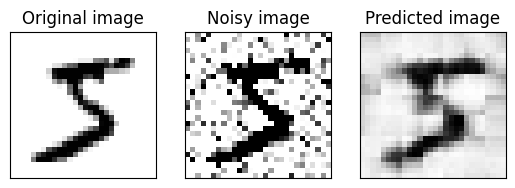

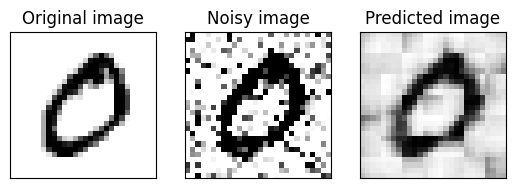

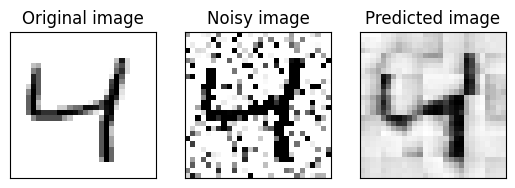

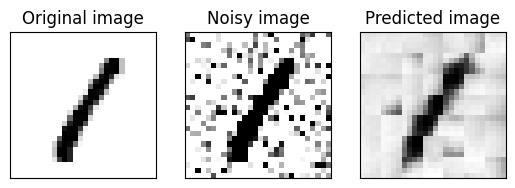

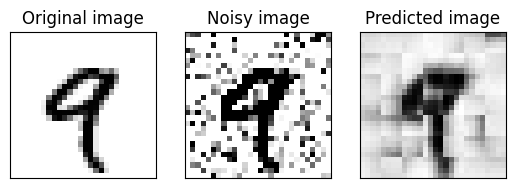

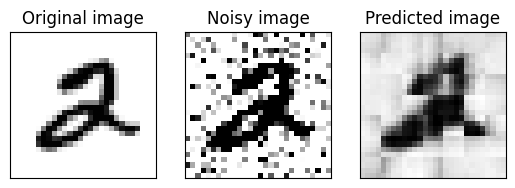

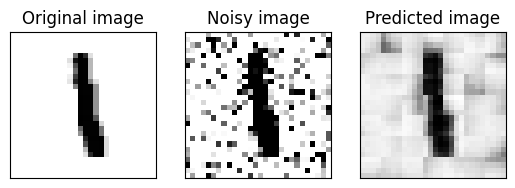

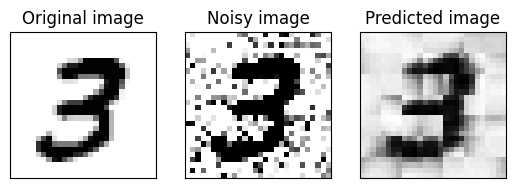

In [109]:
# Vizualization

# Add noise to the test batch
test_batch_example_noisy = add_noise(test_batch_example)

# Pass the noisy images to the autoencoder 
with torch.no_grad():
    test_batch_example_den = model_cnn_den_ae_tr(test_batch_example_noisy)

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(test_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 3, 2)
    plt.imshow(test_batch_example_noisy[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.subplot(1, 3, 3)
    plt.imshow(test_batch_example_den[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()